# RNN, LSTM, GRU 구현 및 비교하기

##0. datasets 라이브러리 다운로드

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 w

##1. 라이브러리 임포트, GPU 설정, 데이터셋 로드

- 필요한 라이브러리 임포트

- GPU 사용 여부 확인해서 device에 할당

- 데이터셋 로드 후 데이터 프레임 확인

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

# 만약 아래에서 정규화 적용 시킬 것이면 사용
# from sklearn.preprocessing import MinMaxScaler

# Colab GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 데이터셋 로드
ds = load_dataset("StockLlama/ETH-USD-2022-01-01_2024-08-30")
df = ds['train'].to_pandas()

# DataFrame 확인
print(df.columns)
print(df.head())


Using device: cuda
Index(['input_ids', 'label'], dtype='object')
                                           input_ids      label
0  [91.308495, 93.06198, 91.06491, 92.02197, 84.8...  28.777820
1  [93.06198, 91.06491, 92.02197, 84.885086, 81.0...  24.001883
2  [91.06491, 92.02197, 84.885086, 81.01954, 74.4...  22.852409
3  [92.02197, 84.885086, 81.01954, 74.42368, 71.4...  23.944717
4  [84.885086, 81.01954, 74.42368, 71.45851, 73.3...  20.007884


##2. 데이터 전처리 및 학습/검증 데이터셋 구성

- 'input_ids'와 'label' 컬럼은 리스트 형태 이므로 numpy 배열로 변환

- 여기서 데이터 정규화 적용 가능

- 80:20으로 학습 데이터와 검증 데이터 분할

- Pytorch 텐서 변환 후 데이터 로더 구성

In [28]:
# numpy 배열로 변환
X = np.array(df['input_ids'].tolist())
y = np.array(df['label'].tolist())

print("X shape:", X.shape)
print("y shape:", y.shape)


# 정규화를 적용할 경우, 여기서 MinMaxScaler 등으로 조정할 수 있음
# X, y 모두 [0,1] 범위로 변환 (데이터 스케일링으로 손실 값 줄일 수 있음)
# from sklearn.preprocessing import MinMaxScaler
# scaler_X = MinMaxScaler()
# X = scaler_X.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
# scaler_y = MinMaxScaler()
# y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# 학습/검증 분할 (80% train, 20% validation)
split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

# 텐서 변환
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)

# DataLoader 구성
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))


X shape: (716, 256)
y shape: (716,)
Train dataset size: 572
Validation dataset size: 144


##3. RNN, LSTM, GRU 모델 정의

- pytorch에 있는 모델 사용

- 각 모델은 단일 recurrent 레이어와 마지막 타임스텝의 은닉 상태를 활용해 최종 예측을 수행하는 Fully Connected 레이어로 구성되어 있음

In [29]:
# 각 모델은 단일 recurrent layer(은닉 크기 64, 1 layer)와 마지막 타임스텝의 출력을 이용한 FC layer로 구성합니다.

class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, output_size=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, output_size=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

rnn_model = RNNModel().to(device)
lstm_model = LSTMModel().to(device)
gru_model = GRUModel().to(device)


##4. 학습 함수 정의

- 에폭마다 학습과 검증 데이터에 대한 MSE 계산하여 반환하도록 함

In [30]:
def train_model(model, optimizer, num_epochs=20):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = nn.MSELoss()(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        epoch_train_loss = running_loss / len(train_dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = nn.MSELoss()(outputs, y_batch)
                running_val_loss += loss.item() * X_batch.size(0)
        epoch_val_loss = running_val_loss / len(val_dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")
    return train_losses, val_losses


##5. 모델 학습 진행

- 각 모델을 300 에폭 만큼 학습 시킴

- Adam 옵티마이저 사용

In [31]:
num_epochs = 300

rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

print("Training RNN model...")
rnn_train_losses, rnn_val_losses = train_model(rnn_model, rnn_optimizer, num_epochs=num_epochs)

print("\nTraining LSTM model...")
lstm_train_losses, lstm_val_losses = train_model(lstm_model, lstm_optimizer, num_epochs=num_epochs)

print("\nTraining GRU model...")
gru_train_losses, gru_val_losses = train_model(gru_model, gru_optimizer, num_epochs=num_epochs)


Training RNN model...
Epoch 1/300 - Train Loss: 1581.322869, Val Loss: 5518.705349
Epoch 2/300 - Train Loss: 1501.548200, Val Loss: 5369.696126
Epoch 3/300 - Train Loss: 1432.424199, Val Loss: 5241.573242
Epoch 4/300 - Train Loss: 1370.782804, Val Loss: 5124.204861
Epoch 5/300 - Train Loss: 1315.622280, Val Loss: 5001.085883
Epoch 6/300 - Train Loss: 1268.118588, Val Loss: 4884.769097
Epoch 7/300 - Train Loss: 1228.826220, Val Loss: 4789.999756
Epoch 8/300 - Train Loss: 1192.666971, Val Loss: 4708.811632
Epoch 9/300 - Train Loss: 1158.017812, Val Loss: 4630.777995
Epoch 10/300 - Train Loss: 1124.977695, Val Loss: 4553.747884
Epoch 11/300 - Train Loss: 1091.969112, Val Loss: 4479.598633
Epoch 12/300 - Train Loss: 1061.151895, Val Loss: 4406.117079
Epoch 13/300 - Train Loss: 1030.880864, Val Loss: 4334.359972
Epoch 14/300 - Train Loss: 1001.542930, Val Loss: 4264.428765
Epoch 15/300 - Train Loss: 973.399668, Val Loss: 4195.891222
Epoch 16/300 - Train Loss: 946.286064, Val Loss: 4128.5496

#6. 학습 경향성 시각화

- 모델별로 학습 경향을 비교할 수 있도록 시각화 함

- 각 모델의 에폭이 진행됨에 따른 학습과 검증 MSE를 볼 수 있음

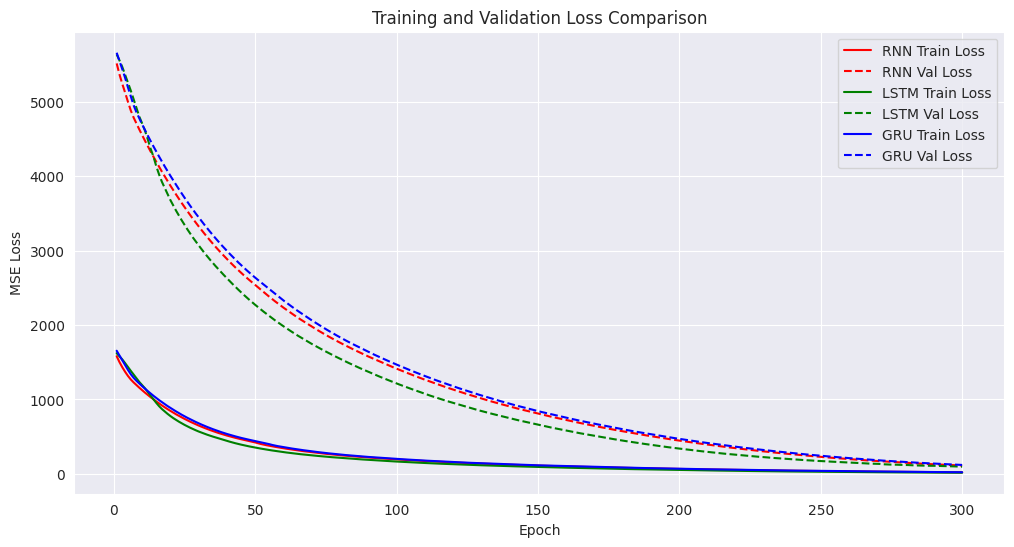

In [32]:
plt.figure(figsize=(12, 6))
epochs = range(1, num_epochs+1)
plt.plot(epochs, rnn_train_losses, 'r-', label="RNN Train Loss")
plt.plot(epochs, rnn_val_losses, 'r--', label="RNN Val Loss")
plt.plot(epochs, lstm_train_losses, 'g-', label="LSTM Train Loss")
plt.plot(epochs, lstm_val_losses, 'g--', label="LSTM Val Loss")
plt.plot(epochs, gru_train_losses, 'b-', label="GRU Train Loss")
plt.plot(epochs, gru_val_losses, 'b--', label="GRU Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss Comparison")
plt.legend()
plt.show()

## 데이터셋 요약

- 이미 전처리 된 시퀀스 형태의 데이터인 input_ids와 예측해야 하는 타겟 값인 label값으로 이루어져 있음

## 적용한 학습 기법

- Recurrent Neural Networks (RNN)
  - 시퀀스 데이터를 처리하는 신경망
  - 이전 상태(hidden state)를 기억하면서 다음 단계로 전달하는 구조
  - 장기 의존성 문제 존재

- Long Short-Term Memory (LSTM)
  - RNN의 장기 의존성 문제를 해결하기 위해 개선된 RNN
  - 셀 상태와 게이트 구조를 사용해 중요한 정보만 유지
  - 그래디언트 소실 문제 해결
  - 구조가 복잡하고 계산량이 많은 단점 존재

- Gated Recurrent Unit (GRU)
  - LSTM을 단순화한 모델
  - 게이트 수를 줄여서 연산량 감소

## 분석 및 고찰

- 모든 모델이 초기에는 높은 로스로 시작하여 300 에폭 동안 꾸준히 감소하는 모습을 보였다.

- RNN 모델
  - Train Loss: 1581, Val Loss: 약 5519에서 시작하여 학습 후 Train Loss: 약 20, Val Loss: 약 112로 크게 감소하였다.
  - 장기 의존성 문제를 해결하지 못하는 경우가 있는 모델이나, 이번 데이터셋에서는 크게 문제가 되지 않은 것 같다.

- LSTM 모델
  -Train Loss: 1621, Val Loss: 약 5640로 시작하여 학습 후 Train Loss:약 15, Val Loss:약 96로 크게 감소하였다.
  -내부적으로 게이트 구조를 통해 장기 의존성을 처리하는 LSTM이지만 상대적으로 단순한 데이터셋 때문인지 RNN과 비교했을 때의 성능이 아주 높지는 않았다.

- GRU 모델
  -Train Loss: 1655, Val Loss: 약 5663로 시작하여 학습 후 Train Loss:약 21, Val Loss:약 119로 크게 감소하였다.
  -LSTM보다 구조가 간단하여 계산량이 적은 GRU 역시 RNN과 LSTM과 비슷한 성능을 보였다.

- 그래도 세 모델 중에서는 가장 구조가 복잡하고 연산량이 많은 LSTM이 손실속도와 최종 성능이 좀 더 좋았다.

- 이번 실험 결과를 통해서 복잡한 모델이 반드시 좋은 성능을 내는 것은 아니라고 생각하게 되었다. 앞으로는 데이터셋과 문제 특성에 따라서 좋은 모델을 채택해야할 것 같다.

## 어려웠던 점
- 시계열 데이터를 다루는게 처음이라 데이터셋 구조를 파악하는데 어려움을 겪었다.

- 처음에 로스가 너무 높아서 문제가 있는 줄 알았는데 단지 데이터 셋의 특성상 값이 크고 그 상태에서 오차 제곱의 평균을 구하는 MSE를 사용하였기 때문이었다. 로스 값을 줄이기 위해서 MinMaxScaler를 이용한 정규화를 진행하였었는데 나중에 학습 경향성을 판단할 때 좋지 않아서 그냥 별도의 정규화 없이 진행하였다.

